# Classification based on Quickdraw Dataset

### Imports

In [1]:
import os
from PIL import Image
import json

import random
import numpy as np
import cairocffi as cairo
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.io import read_image, ImageReadMode
from torch.optim.lr_scheduler import StepLR

## Functions to preprocess the data

In [2]:
# Get the classes that will be used
def load_classes(file_path):
    res = {}
    count = 0
    for line in open(file_path, 'r'):
        res[count] = line.rstrip()
        count+=1
    return res

In [3]:
# This function is taken from the original GitHub of the QuickDrawDataset
def vector_to_raster(vector_images, side=64, line_diameter=16, padding=16, bg_color=(0,0,0), fg_color=(1,1,1)):
    
    original_side = 256.
    
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, side, side)
    ctx = cairo.Context(surface)
    ctx.set_antialias(cairo.ANTIALIAS_BEST)
    ctx.set_line_cap(cairo.LINE_CAP_ROUND)
    ctx.set_line_join(cairo.LINE_JOIN_ROUND)
    ctx.set_line_width(line_diameter)

    # scale to match the new size
    # add padding at the edges for the line_diameter
    # and add additional padding to account for antialiasing
    total_padding = padding * 2. + line_diameter
    new_scale = float(side) / float(original_side + total_padding)
    ctx.scale(new_scale, new_scale)
    ctx.translate(total_padding / 2., total_padding / 2.)

    raster_images = []
    for vector_image in vector_images:
        # clear background
        ctx.set_source_rgb(*bg_color)
        ctx.paint()
        
        bbox = np.hstack(vector_image).max(axis=1)
        offset = ((original_side, original_side) - bbox) / 2.
        offset = offset.reshape(-1,1)
        centered = [stroke + offset for stroke in vector_image]

        # draw strokes, this is the most cpu-intensive part
        ctx.set_source_rgb(*fg_color)        
        for xv, yv in centered:
            ctx.move_to(xv[0], yv[0])
            for x, y in zip(xv, yv):
                ctx.line_to(x, y)
            ctx.stroke()

        data = surface.get_data()
        raster_image = np.copy(np.asarray(data)[::4])
        raster_images.append(raster_image)
    
    return raster_images

In [4]:
# return the data as an array containing images as 1D arrays
def load_data(sample, n_images, dimension):
    sample_data = [json.loads(line) for line in open(f'data/full_simplified_{sample}.ndjson', 'r')]
    sample_data = random.sample(sample_data, k=n_images)
    vector_images = [drawing_data['drawing'] for drawing_data in sample_data]
    return np.array(vector_to_raster(vector_images, side=dimension))

In [5]:
# Saves the datasets as images in the "images" folder
def save_png(drawing_class, data, dimension):
    if not os.path.exists(f"images/{drawing_class}"): 
        os.makedirs(f"images/{drawing_class}")

    count = 0
    for image_arr in data:
        image_arr = np.reshape(image_arr, (dimension, -1))
        img = Image.fromarray(image_arr, "L")
        img.save(f"images/{drawing_class}/{drawing_class}_{count}.png")
        count += 1
    

In [6]:
def preprocess_data(classes, n_images, img_dim, train_prop=0.8):
  train_file_names = []
  train_labels = []
  test_file_names = []
  test_labels = []
  
  for key, drawing_class in classes.items():
      print(f"Processing {drawing_class} data")
      data = load_data(drawing_class, n_images, dimension = img_dim)
      save_png(drawing_class, data, img_dim)
      file_names = [f"images/{drawing_class}/{drawing_class}_{i}.png" for i in range(len(data))]
      labels = np.full(len(data), key)
      train_file_names.append(file_names[:(int)(n_images*train_prop)])
      train_labels.append(labels[:(int)(n_images*train_prop)])
      test_file_names.append(file_names[(int)(n_images*train_prop):])
      test_labels.append(labels[(int)(n_images*train_prop):])

  # Save the file names and labels
  train_file_names = np.array(train_file_names).flatten()
  json.dump(train_file_names.tolist(), open("train_file_names.json", 'w'))
  train_labels = np.array(train_labels).flatten()
  json.dump(train_labels.tolist(), open("train_labels.json", 'w'))
  test_file_names = np.array(test_file_names).flatten()
  json.dump(test_file_names.tolist(), open("test_file_names.json", 'w'))
  test_labels = np.array(test_labels).flatten()
  json.dump(test_labels.tolist(), open("test_labels.json", 'w'))

In [7]:
def calcMeanStd(datasets):
    data = []
    for dataset in datasets:
        for file_name in dataset:
            img = Image.open(file_name)
            img = np.array(img)
            data.append(img)
    data = np.array(data)
    return np.mean(data), np.std(data)

## The Network

### Dataset class that represent the Dataset

In [8]:
class QuickDrawDataset(Dataset):
    def __init__(self, file_names, labels, transform=None):
        self.file_names = file_names
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.file_names[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

### CNN class

In [9]:
class Net(nn.Module):
    def __init__(self, n_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3) # To increase maybe to 16
        self.conv2 = nn.Conv2d(8, 16, 3)# To increase maybe to 32
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(400, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

### Functions for the CNN

In [18]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    interval_losses = []
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        interval_losses.append(loss.item())
        optimizer.step()
        if (batch_idx + 1) % log_interval == 0:
            mean_interval_loss = np.mean(interval_losses)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx * len(data)) + 1, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), mean_interval_loss))
            losses.append(mean_interval_loss)
            interval_losses = []
    return losses

In [11]:
def test(model, device, test_loader):
    print("Testing")
    model.eval()
    predicted = []
    truth = []
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            cuda_data, cuda_target = data.to(device), target.to(device)
            output = model(cuda_data)
            test_loss += F.nll_loss(output, cuda_target, reduction='sum').item()  # sum up batch loss
            pred = output.cpu().argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            predicted.extend(pred)
            truth.extend(target)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, predicted, truth

## Main part

Variables describing the data

In [12]:
# Images will be 64x64
img_dim = 28
# Number of images taken for each animal
n_images = 1000
# Proportion used for to train the model
train_prop = 0.8

Store the classes in a dictionnary with their index

In [13]:
classes = load_classes("class_names.txt")
n_classes = len(classes)
print(classes)

{0: 'axe', 1: 'bicycle', 2: 'flower', 3: 'snowman', 4: 'umbrella', 5: 'key', 6: 'castle', 7: 'bird', 8: 'windmill', 9: 'pineapple'}




The preprocess function do multiple things : <br>
- Build the png images from the json files. Like this the PyTorch Dataset object will search the images directly in the files
- Separate the dataset in train and test datasets by storing the names of the images in json files

__This function can take a lot of time to run, so it is designed to be run only once.__ The results are stored in the folder 'data' and the json files.

In [14]:
preprocess_data(classes, n_images=n_images, img_dim=img_dim, train_prop=train_prop)

Loading axe data
Loading bicycle data
Loading flower data
Loading snowman data
Loading umbrella data
Loading key data
Loading castle data
Loading bird data
Loading windmill data
Loading pineapple data


Put the data in memory

In [14]:
train_files = json.load(open("train_file_names.json", 'r'))
test_files = json.load(open("test_file_names.json", 'r'))

train_labels = json.load(open("train_labels.json", 'r'))
test_labels = json.load(open("test_labels.json", 'r'))

Create the Datasets and Loaders

In [15]:
preprocessNoNorm = transforms.Compose([
        transforms.ToTensor(),
        ])

train_dataset = QuickDrawDataset(train_files, train_labels, transform=preprocessNoNorm)
test_dataset = QuickDrawDataset(test_files, test_labels, transform=preprocessNoNorm)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle=True)

### Training the model

In [21]:
# Learning rate
learning_rate = 1
# Momentum
gamma = 0.7
# Number of epochs
epochs = 3
# Interval between logging
log_interval = 1000

In [22]:
model = Net(n_classes)

optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
test_losses = []

for epoch in range(1, epochs + 1):
    train_losses += train(model, device, train_loader, optimizer, epoch, log_interval)
    loss, predicted, truth = test(model, device, test_loader)
    test_losses.append(loss)
    scheduler.step()

Train Epoch: 1 [1000/8000 (12%)]	Loss: 1.846733
Train Epoch: 1 [2000/8000 (25%)]	Loss: 1.398024
Train Epoch: 1 [3000/8000 (37%)]	Loss: 1.150541
Train Epoch: 1 [4000/8000 (50%)]	Loss: 1.055436
Train Epoch: 1 [5000/8000 (62%)]	Loss: 1.006638
Train Epoch: 1 [6000/8000 (75%)]	Loss: 0.936208
Train Epoch: 1 [7000/8000 (87%)]	Loss: 0.930124
Train Epoch: 1 [8000/8000 (100%)]	Loss: 0.917019
Testing

Test set: Average loss: 0.7554, Accuracy: 1548/2000 (77%)

Train Epoch: 2 [1000/8000 (12%)]	Loss: 0.865394
Train Epoch: 2 [2000/8000 (25%)]	Loss: 0.756836
Train Epoch: 2 [3000/8000 (37%)]	Loss: 0.787182
Train Epoch: 2 [4000/8000 (50%)]	Loss: 0.770260
Train Epoch: 2 [5000/8000 (62%)]	Loss: 0.816692
Train Epoch: 2 [6000/8000 (75%)]	Loss: 0.856942
Train Epoch: 2 [7000/8000 (87%)]	Loss: 0.827413
Train Epoch: 2 [8000/8000 (100%)]	Loss: 0.754237
Testing

Test set: Average loss: 0.6546, Accuracy: 1585/2000 (79%)

Train Epoch: 3 [1000/8000 (12%)]	Loss: 0.731221
Train Epoch: 3 [2000/8000 (25%)]	Loss: 0.77158

# Visualizations

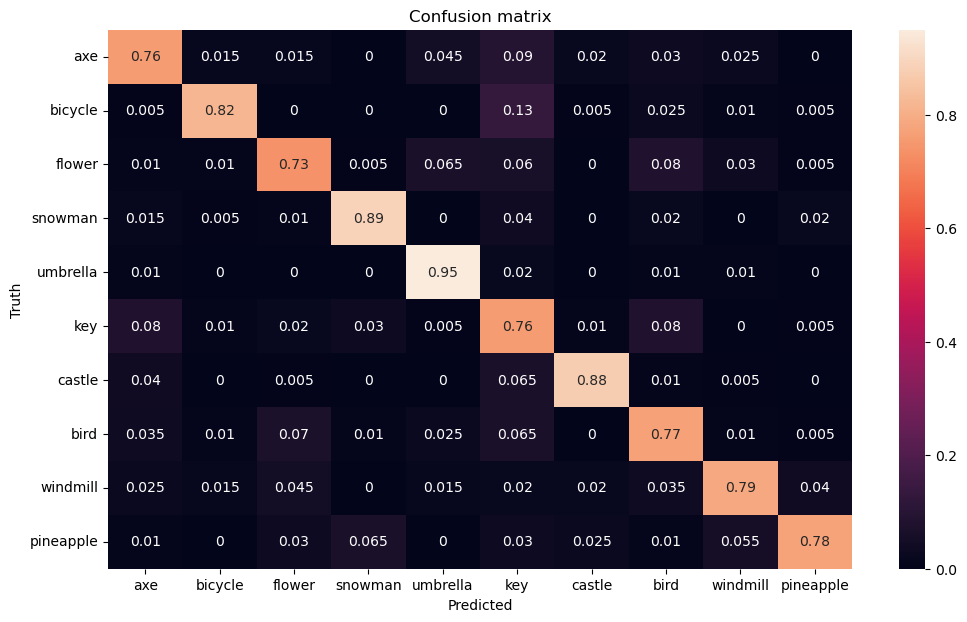

In [28]:
cf_matrix = confusion_matrix(truth, predicted)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes.values()],
                     columns = [i for i in classes.values()])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.title("Confusion matrix")
#plt.savefig("figures/confusion_matrix.png")
plt.show()

### Global loss

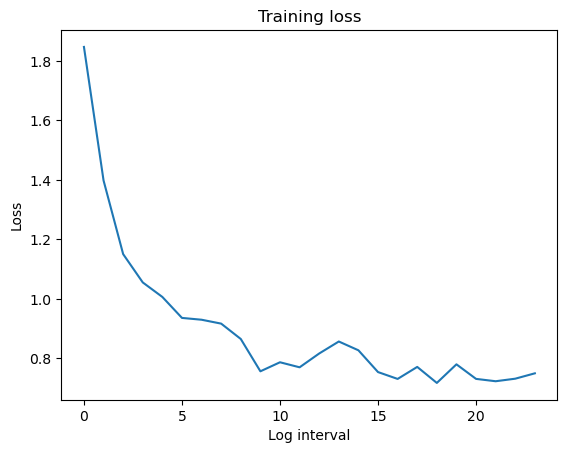

In [32]:
plt.plot(train_losses, label='Training loss')
plt.xlabel("Log interval")
plt.ylabel("Loss")
plt.title("Training loss")
#plt.savefig("figures/training_loss.png")
plt.show()

### Loss per epoch

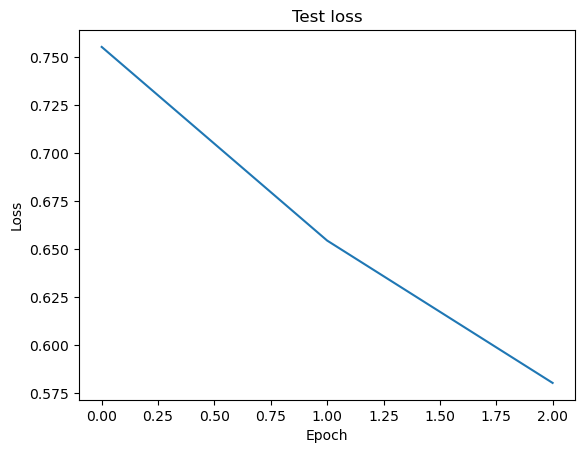

In [34]:
plt.plot(test_losses, label='Training loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Test loss")
#plt.savefig("figures/test_loss.png")
plt.show()

### Test to predict on one image

In [26]:
image = Image.open("images/flower/flower_4.png")
image = preprocessNoNorm(image)
model.to("cpu")
model.eval()
output = model(image.unsqueeze(0))
pred = output.argmax(dim=1, keepdim=True)
print(output)
print(pred[0][0].item())
print(classes[pred[0][0].item()])

tensor([[-5.6532, -5.2138, -0.6929, -2.4633, -3.6766, -3.5549, -5.2944, -1.0658,
         -7.1741, -6.4026]], grad_fn=<LogSoftmaxBackward0>)
2
flower


For the data :
- sort to keep only the recognized drawings / quality drawings

For the CNN:
- (batch normailzation)

For vizualization and documentation:
- learning rate
- number of epochs
- data size
- data quality
- modify CNN : 
  - number of layers
  - pooling
  - number of neurons


- evolution of the error with epochs
